In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
from implicit.bpr import BayesianPersonalizedRanking
from collections import defaultdict
import seaborn as sns

Load data

In [15]:
    # Loads all data from the MovieLens 100k dataset
data = pd.read_csv('ml-100k/ml-100k/u.data', sep='\t', names=['userID', 'itemID', 'rating', 'timestamp'])
genre = pd.read_csv('ml-100k/ml-100k/u.genre', sep='|', names=['genre', 'genreID'])
item = pd.read_csv('ml-100k/ml-100k/u.item', sep='|', names=['itemID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 
    'IMDbURL', 'unknown', 'Action', 'Adventure','Animation', 'Children\'s', 'Comedy', 
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir','Horror', 'Musical', 
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')
item['releaseDate'] = pd.to_datetime(item['releaseDate'], format='%d-%b-%Y')
item['videoReleaseDate'] = pd.to_datetime(item['videoReleaseDate'], format='%d-%b-%Y')
occupation = pd.read_csv('ml-100k/ml-100k/u.occupation', names=['occupation'])
user = pd.read_csv('ml-100k/ml-100k/u.user', sep='|', names=['userID', 'age', 'gender', 'occupation', 'zipCode'])

Plots of ratings and interactions distributions

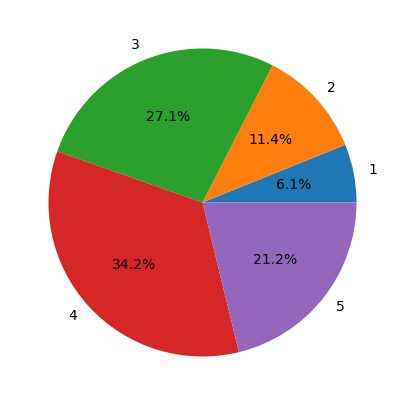

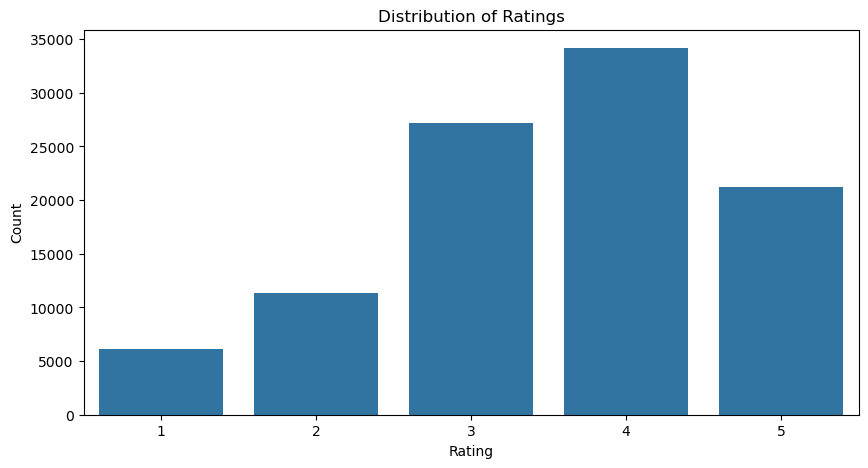

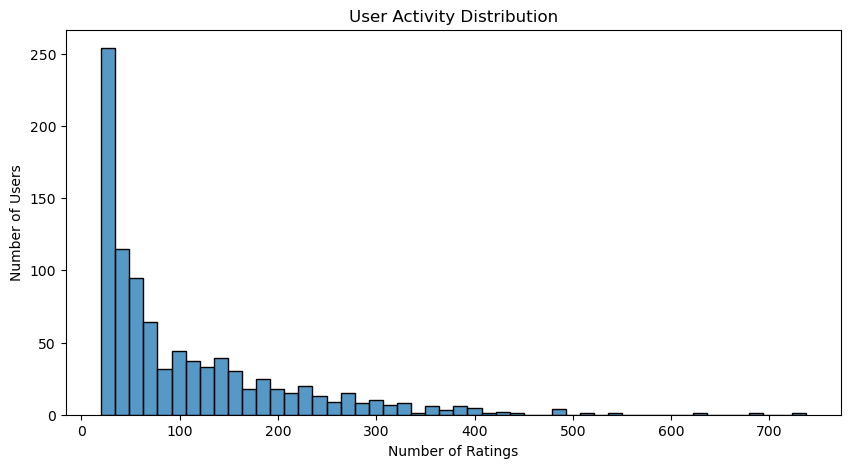

In [16]:
        # Displays some general information and distributions of the dataset
    
    # Shows distribution of ratings in a pie chart
data_ratings = data['rating'].value_counts().sort_index().reset_index()
plt.figure(figsize=(5,5))
plt.pie(data_ratings['count'], labels=data_ratings['rating'], autopct='%1.1f%%')
plt.show()  

    # Shows distribution of ratings in a bar chart
plt.figure(figsize=(10,5))
sns.barplot(x='rating', y='count', data=data_ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

    # Shows user activity distribution in a histogram
user_activity = data.groupby('userID').size()
plt.figure(figsize=(10,5))
sns.histplot(user_activity, bins=50)
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


Creating pairwise preferences (Not used, as implicit library is used instead - might be possible future work)

In [ ]:
#     # Creates pairwise preferences from the ratings data by comparing i and j items
#     # Not used, but might still count as a bonus to demonstrate how it could be done
# def create_pairwise_preferences(data):
#     pairwise_prefs = []
#     user_groups = data.groupby('userID')
    
#     for user_id, user_data in user_groups:
#         rated_items = user_data[['itemID', 'rating']].values
#         for i in range(len(rated_items)):
#             item_i, rating_i = rated_items[i]
#             for j in range(len(rated_items)):
#                 item_j, rating_j = rated_items[j]
#                 if rating_i > rating_j:
#                     pairwise_prefs.append((user_id, int(item_i), int(item_j)))
    
#     return pd.DataFrame(pairwise_prefs, columns=['userID', 'positive_itemID', 'negative_itemID'])

# pairwise_data = create_pairwise_preferences(data)

Training the model

In [18]:
    # No need for pairwise preferences as implicit library handles everything related ot that

    # Creates implicit feedback user-item interaction matrix from the pairwise preferences
user_item_matrix = sparse.csr_matrix((data['rating'], (data['userID'], data['itemID'])), shape=(data['userID'].max()+1, data['itemID'].max()+1))

    # Train model. Note: iterations and other parameters can be adjusted, but they have minimal impact on results above 200 iterations (+-0.2%)
    # Testing showed that 300 iterations provides most optimal results (~96.6% accuracy)
bpr_model = BayesianPersonalizedRanking(factors=50, learning_rate=0.01, regularization=0.01, iterations=300)
bpr_model.fit(user_item_matrix)


100%|██████████| 300/300 [00:02<00:00, 126.69it/s, train_auc=96.48%, skipped=30.44%]


In [19]:
    # Splits data into training and testing sets using sklearn - 80/20% split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Training data: {len(train_data)} ratings")
print(f"Test data: {len(test_data)} ratings")

Training data: 80000 ratings
Test data: 20000 ratings


In [20]:
    # Returns reccomendations for single user
def recommended_movies_for_user(model, user_id, user_item_matrix, number_of_recommendations):
    user_items = set(user_item_matrix[user_id - 1].indices + 1)
    all_items = set(range(1, user_item_matrix.shape[1] + 1))
    unrated_items = list(all_items - user_items)
    
    if not unrated_items:
        return []
    
       # Latent factors
    user_factor = model.user_factors[user_id - 1]
    item_factors = model.item_factors[np.array(unrated_items) - 1]
    
    scores = np.dot(user_factor, item_factors.T)
    top_indices = np.argsort(scores)[::-1][:number_of_recommendations]
    recommendations = [unrated_items[i] for i in top_indices]
    
    return recommendations

def get_recommended_movies_data(recommendations):
    movie_items = item[item['itemID'].isin(recommendations)]
    movie_items = movie_items.set_index('itemID').loc[recommendations].reset_index()
    movie_items.index = range(1, len(movie_items) + 1)
    return movie_items[['itemID', 'movieTitle', 'releaseDate']]

user_id = 1
recommended_movies_IDs = recommended_movies_for_user(bpr_model, user_id, user_item_matrix, 10)
print(f"Recommended movie IDs: {recommended_movies_IDs}")
print(f"Top recommendations for user {user_id}:")
recommended_movies = get_recommended_movies_data(recommended_movies_IDs)
print(recommended_movies)

Recommended movie IDs: [51, 182, 101, 175, 57, 122, 289, 295, 2, 259]
Top recommendations for user 1:
    itemID                   movieTitle releaseDate
1       51   Legends of the Fall (1994)  1994-01-01
2      182            GoodFellas (1990)  1990-01-01
3      101           Heavy Metal (1981)  1981-03-08
4      175                Brazil (1985)  1985-01-01
5       57                Priest (1994)  1994-01-01
6      122        Cable Guy, The (1996)  1996-06-14
7      289                 Evita (1996)  1996-12-25
8      295             Breakdown (1997)  1997-05-02
9        2             GoldenEye (1995)  1995-01-01
10     259  George of the Jungle (1997)  1997-01-01


Group Recommendations

In [21]:
        # Groups - random
def create_random_group(number_of_users):
        group = np.random.choice(data['userID'].unique(), number_of_users, replace=False).tolist()
        return group

random_group = create_random_group(5)
print(f"Random group of users: {random_group}\n")
for user_id in random_group:
        recommended_movies_IDs = recommended_movies_for_user(bpr_model, user_id, user_item_matrix, 5)
        print(f"Top recommendations for user {user_id}:")
        recommended_movies = get_recommended_movies_data(recommended_movies_IDs)
        print(recommended_movies, "\n")


Random group of users: [105, 512, 397, 405, 353]

Top recommendations for user 105:
   itemID                                      movieTitle releaseDate
1     316                       As Good As It Gets (1997)  1997-12-23
2    1068  Star Maker, The (Uomo delle stelle, L') (1995)  1996-03-01
3     299                                  Hoodlum (1997)  1997-08-22
4    1265                                Star Maps (1997)  1997-01-01
5    1024                            Mrs. Dalloway (1997)  1997-01-01 

Top recommendations for user 512:
   itemID               movieTitle releaseDate
1     332    Kiss the Girls (1997)  1997-01-01
2     333         Game, The (1997)  1997-01-01
3     877    Excess Baggage (1997)  1997-01-01
4     351  Prophecy II, The (1998)  1998-01-16
5     324      Lost Highway (1997)  1997-02-21 

Top recommendations for user 397:
   itemID                          movieTitle releaseDate
1     686             Perfect World, A (1993)  1993-01-01
2     761                 

In [22]:
    # Scoring and strategies for group recommendations consisting multiple users
def get_user_scores_for_all_items(model, user_id, user_item_matrix):
    user_factor = model.user_factors[user_id - 1]
    item_factors = model.item_factors
    scores = np.dot(user_factor, item_factors.T)
    return scores

def average_strategy(model, group, user_item_matrix, top_k=10):
    all_scores = []
    
    for user_id in group:
        user_scores = get_user_scores_for_all_items(model, user_id, user_item_matrix)
        all_scores.append(user_scores)
    
    avg_scores = np.mean(all_scores, axis=0)
    
    for user_id in group:
        rated_items = user_item_matrix[user_id - 1].indices
        avg_scores[rated_items] = -np.inf
    
    top_items = np.argsort(avg_scores)[::-1][:top_k]
    return (top_items + 1).tolist()

group_recommended_movie_IDs_avg_strat = average_strategy(bpr_model, random_group, user_item_matrix)
print(f"Top recomendations for group with users - {random_group}, using average strategy: ")
recommended_movies_average_strategy = get_recommended_movies_data(group_recommended_movie_IDs_avg_strat)
print(recommended_movies_average_strategy)

Top recomendations for group with users - [105, 512, 397, 405, 353], using average strategy: 
    itemID                        movieTitle releaseDate
1      327                   Cop Land (1997)  1997-01-01
2      351           Prophecy II, The (1998)  1998-01-16
3      874               Career Girls (1997)  1997-08-08
4      316         As Good As It Gets (1997)  1997-12-23
5      265  Hunt for Red October, The (1990)  1990-01-01
6      335         How to Be a Player (1997)  1997-01-01
7      753           Burnt By the Sun (1994)  1994-01-01
8      750                    Amistad (1997)  1997-12-18
9      352                Spice World (1997)  1997-01-01
10     882          Washington Square (1997)  1997-01-01


In [23]:
    # Also a strategy for Least Misery, similar to Average but with some minor adjustments
def least_misery_strategy(model, group, user_item_matrix, top_k=10):
    all_scores = []
    for user_id in group:
        user_scores = get_user_scores_for_all_items(model, user_id, user_item_matrix)
        all_scores.append(user_scores)
    
    min_scores = np.min(all_scores, axis=0)
    for user_id in group:
        rated_items = user_item_matrix[user_id - 1].indices
        min_scores[rated_items] = -np.inf
    
    top_items = np.argsort(min_scores)[::-1][:top_k]
    return (top_items + 1).tolist()

group_recommended_movie_IDs_least_misery_strat = least_misery_strategy(bpr_model, random_group, user_item_matrix)
print(f"Top recomendations for group with users - {random_group}, using least misery strategy: ")
recommended_movies_least_misery_strategy = get_recommended_movies_data(group_recommended_movie_IDs_least_misery_strat)
print(recommended_movies_least_misery_strategy)


Top recomendations for group with users - [105, 512, 397, 405, 353], using least misery strategy: 
    itemID                    movieTitle releaseDate
1     1596      Nemesis 2: Nebula (1995)  1995-01-01
2     1597         Romper Stomper (1992)  1992-01-01
3      753       Burnt By the Sun (1994)  1994-01-01
4      299                Hoodlum (1997)  1997-08-22
5        1              Toy Story (1995)  1995-01-01
6     1084  Anne Frank Remembered (1995)  1996-02-23
7      516             Local Hero (1983)  1983-01-01
8     1656            Little City (1998)  1998-02-20
9     1107         Beyond Rangoon (1995)  1995-01-01
10    1598       City of Industry (1997)  1997-03-14


In [24]:
    # Group recommendations based on similar metric, in this case - age, gender (also in the future occupation could be used)
def create_age_based_group(number_of_users, min_age, max_age):
    age_filtered_users = user[(user['age'] >= min_age) & (user['age'] <= max_age)]['userID'].unique()    
    group = np.random.choice(age_filtered_users, number_of_users, replace=False).tolist()
    return group

def create_gender_based_group(number_of_users, gender):
    gender_filtered_users = user[user['gender'] == gender]['userID'].unique()
    group = np.random.choice(gender_filtered_users, number_of_users, replace=False).tolist()
    return group

In [25]:
    # Age-based group - different strategies
age_based_group = create_age_based_group(5, 20, 35)
print(f"Age-based group of users: {age_based_group}\n")
age_based_group_avg_strat = average_strategy(bpr_model, age_based_group, user_item_matrix)
recommended_movies_age_based_group_avg = get_recommended_movies_data(age_based_group_avg_strat)
print(f"Top recommendations for age-based group with users - {age_based_group}, using average strategy: ")
print(recommended_movies_age_based_group_avg)

age_based_group_least_misery_strat = least_misery_strategy(bpr_model, age_based_group, user_item_matrix)
recommended_movies_age_based_group_least_misery = get_recommended_movies_data(age_based_group_least_misery_strat)
print(f"\n\nTop recommendations for age-based group with users - {age_based_group}, using least misery strategy: ")
print(recommended_movies_age_based_group_least_misery)

Age-based group of users: [250, 649, 668, 356, 190]

Top recommendations for age-based group with users - [250, 649, 668, 356, 190], using average strategy: 
    itemID                                      movieTitle releaseDate
1      191                                  Amadeus (1984)  1984-01-01
2      346                             Jackie Brown (1997)  1997-01-01
3      530               Man Who Would Be King, The (1975)  1975-01-01
4      339                                 Mad City (1997)  1997-01-01
5      304                            Fly Away Home (1996)  1996-09-13
6      491            Adventures of Robin Hood, The (1938)  1938-01-01
7      312  Midnight in the Garden of Good and Evil (1997)  1997-01-01
8      290                         Fierce Creatures (1997)  1997-01-10
9       49                                     I.Q. (1994)  1994-01-01
10     710                       Better Off Dead... (1985)  1985-01-01


Top recommendations for age-based group with users - [250, 

In [26]:
    # Gender-based group - Female - different strategies
gender_based_group = create_gender_based_group(5, 'F')
print(f"gender-based group of users: {gender_based_group}\n")
gender_based_group_avg_strat = average_strategy(bpr_model, gender_based_group, user_item_matrix)
recommended_movies_gender_based_group_avg = get_recommended_movies_data(gender_based_group_avg_strat)
print(f"Top recommendations for gender-based group with users - {gender_based_group}, using average strategy: ")
print(recommended_movies_gender_based_group_avg)

gender_based_group_least_misery_strat = least_misery_strategy(bpr_model, gender_based_group, user_item_matrix)
recommended_movies_gender_based_group_least_misery = get_recommended_movies_data(gender_based_group_least_misery_strat)
print(f"\n\nTop recommendations for gender-based group with users - {gender_based_group}, using least misery strategy: ")
print(recommended_movies_gender_based_group_least_misery)

gender-based group of users: [417, 704, 450, 88, 52]

Top recommendations for gender-based group with users - [417, 704, 450, 88, 52], using average strategy: 
    itemID                                 movieTitle releaseDate
1      826                        Phantom, The (1996)  1996-06-07
2      757              Across the Sea of Time (1995)  1995-01-01
3      281                     River Wild, The (1994)  1994-01-01
4        4                          Get Shorty (1995)  1995-01-01
5     1094  Thin Line Between Love and Hate, A (1996)  1996-04-03
6      979                 Trigger Effect, The (1996)  1996-08-30
7      824               Great White Hype, The (1996)  1996-05-03
8     1103                               Trust (1990)  1990-01-01
9      291                      Absolute Power (1997)  1997-02-14
10     130                         Kansas City (1996)  1996-08-16


Top recommendations for gender-based group with users - [417, 704, 450, 88, 52], using least misery strategy: 
 

Evaluation metrics

In [27]:
    # Evaluation functions
def precision_at_k(recommended, relevant, k):
    if len(recommended) == 0:
        return 0.0
    return len(set(recommended[:k]) & set(relevant)) / min(k, len(recommended))

def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0.0
    return len(set(recommended[:k]) & set(relevant)) / len(relevant)
    

    # Retrieves best items for user from test data, which is then used for evaluation as "relevant" items
def get_test_items_for_user(user_id, test_data):
    return test_data[test_data['userID'] == user_id]['itemID'].tolist()

In [28]:
    # Individual user evaluation
def evaluate_individual_recommendations(user_id, k):
    recommended_ids = recommended_movies_for_user(bpr_model, user_id, user_item_matrix, k)
    recommended = recommended_ids if isinstance(recommended_ids, list) else recommended_ids['itemID'].tolist()
    
    relevant = get_test_items_for_user(user_id, test_data)
    precision = precision_at_k(recommended, relevant, k)
    recall = recall_at_k(recommended, relevant, k)
    
    return {
        'user_id': user_id,
        'precision': precision,
        'recall': recall
    }

individual_precisions = []
individual_recalls = []
print("\nIndividual user evaluations from age-based group: ")
for user_id in age_based_group:
    evaluation = evaluate_individual_recommendations(user_id, k=50)
    print(evaluation)

    individual_precisions.append(evaluation['precision'])
    individual_recalls.append(evaluation['recall'])


Individual user evaluations from age-based group: 
{'user_id': 250, 'precision': 0.06, 'recall': 0.1}
{'user_id': 649, 'precision': 0.0, 'recall': 0.0}
{'user_id': 668, 'precision': 0.0, 'recall': 0.0}
{'user_id': 356, 'precision': 0.04, 'recall': 0.2857142857142857}
{'user_id': 190, 'precision': 0.02, 'recall': 0.1}


In [29]:
    # Group evaluation
def evaluate_group_recommendations(group, k):
    recommended_ids = average_strategy(bpr_model, group, user_item_matrix, top_k=k)
    recommended = recommended_ids if isinstance(recommended_ids, list) else recommended_ids['itemID'].tolist()
    
    relevant = []
    for user_id in group:
        relevant.extend(get_test_items_for_user(user_id, test_data))
    
    precision = precision_at_k(recommended, relevant, k)
    recall = recall_at_k(recommended, relevant, k)
    
    return {
        'group': group,
        'precision': precision,
        'recall': recall
    }

print("Group evaluations from age-based group: ")
age_group_evaluation = evaluate_group_recommendations(age_based_group, k=50)
print(age_group_evaluation)

print("\n\nGroup evaluation from gender-based group: ")
gender_group_evaluation = evaluate_group_recommendations(gender_based_group, k=50)
print(gender_group_evaluation)

Group evaluations from age-based group: 
{'group': [250, 649, 668, 356, 190], 'precision': 0.1, 'recall': 0.08771929824561403}


Group evaluation from gender-based group: 
{'group': [417, 704, 450, 88, 52], 'precision': 0.08, 'recall': 0.019230769230769232}


Plots for results display

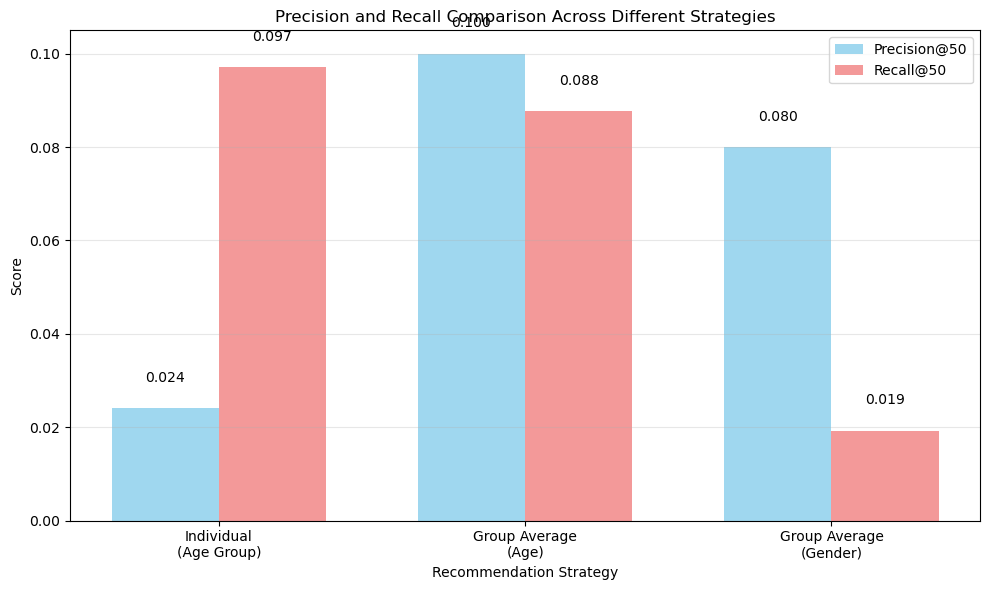

In [30]:
def plot_evaluation_comparison():
    strategies = ['Individual\n(Age Group)', 'Group Average\n(Age)', 'Group Average\n(Gender)']
    precision_scores = [
        np.mean(individual_precisions),
        age_group_evaluation['precision'],
        gender_group_evaluation['precision']
    ]
    recall_scores = [
        np.mean(individual_recalls),
        age_group_evaluation['recall'],
        gender_group_evaluation['recall']
    ]
    
    x = np.arange(len(strategies))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, precision_scores, width, label='Precision@50', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, recall_scores, width, label='Recall@50', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Recommendation Strategy')
    ax.set_ylabel('Score')
    ax.set_title('Precision and Recall Comparison Across Different Strategies')
    ax.set_xticks(x)
    ax.set_xticklabels(strategies)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_evaluation_comparison()